In [ ]:
!mkdir dataset
!mkdir dataset/images

In [ ]:
import os
import base64
import requests
import json

# OpenAI API Key
api_key = 'openAI-token'

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your images folder
folder_path = "./dataset/images"

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

# Question to ask for each image
question_std = "Generate a detailed description about this image"



# Function to process each image and get the description
def process_image(image_path, image_name, question):
    base64_image = encode_image(image_path)

    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": question
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens": 300
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response_json = response.json()
    return response_json['choices'][0]['message']['content']

# List to store all JSON data
all_json_data = []

# Process each image in the folder
for image_name in os.listdir(folder_path):
    if image_name.endswith((".jpg", ".jpeg", ".png")):
        image_name_without_ext = image_name.split('.')[0]
        image_path = os.path.join(folder_path, image_name)
        if image_name_without_ext not in question_dict:
          continue
        question = question_dict[image_name_without_ext]
        formatted_answers = process_image(image_path, image_name, question)

        json_data = {
            "id": image_name.split('.')[0],
            "image": image_name,
            "conversations": [
                {
                    "from": "human",
                    "value": question_std
                },
                {
                    "from": "gpt",
                    "value": formatted_answers
                }
            ]
        }

        all_json_data.append(json_data)

# Save the results to a JSON file
output_file = "output.json"
with open(output_file, "w") as outfile:
    json.dump(all_json_data, outfile, indent=4)

print(f"Data has been saved to {output_file}")

Data has been saved to output.json


In [ ]:
# Install preprocessing libraries
!pip install datasets
!pip install --upgrade --force-reinstall Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.4.0
    Uninstalling pillow-10.4.0:
      Successfully uninstalled pillow-10.4.0


In [ ]:
# Imports
from datasets import load_dataset
from PIL import Image
from io import BytesIO
import requests
import os
import json
import uuid

# Check PIL import
import PIL.Image

# Define preprocessing functions
def process_and_save(dataset, output_folder, subset_name):
    # Define image subfolder within output folder
    subset_folder = os.path.join(output_folder, subset_name)
    image_subfolder = os.path.join(output_folder, 'images')

    if not os.path.exists(image_subfolder):
        os.makedirs(image_subfolder)

    if not os.path.exists(subset_folder):
        os.makedirs(subset_folder)

    # Initialize list to hold all JSON data
    json_data_list = []

    # Process and save images and labels
    for item in dataset:
        # Load image if it's a URL or a file path
        if isinstance(item['image'], str):
            response = requests.get(item['image'])
            image = Image.open(BytesIO(response.content))
        else:
            image = item['image']  # Assuming it's a PIL.Image object

        # Create a unique ID for each image
        unique_id = str(uuid.uuid4())

        # Define image path
        image_path = os.path.join(image_subfolder, f"{unique_id}.jpg")

        # Save image
        image.save(image_path)

        # Remove duplicates and format answers
        answers = item['answers']
        unique_answers = list(set(answers))
        formatted_answers = ", ".join(unique_answers)

        # Structure for LLaVA JSON
        json_data = {
            "id": unique_id,
            "image": f"{unique_id}.jpg",
            "conversations": [
                {
                    "from": "human",
                    "value": item['question']
                },
                {
                    "from": "gpt",
                    "value": formatted_answers
                }
            ]
        }

        # Append to list
        json_data_list.append(json_data)

    # Save the JSON data list to a file
    json_output_path = os.path.join(output_folder, subset_name, 'dataset.json')
    with open(json_output_path, 'w') as json_file:
        json.dump(json_data_list, json_file, indent=4)

def save_dataset(dataset_name, output_folder, class_name, subset_name, val_samples=None):
    # Load the dataset from Hugging Face
    dataset = load_dataset(dataset_name, split=subset_name)

    # Filter for images with the specified class in 'question_type'
    filtered_dataset = [item for item in dataset if item['question_type'] == class_name]

    # Determine the split for training and validation
    if val_samples is not None and subset_name == 'train':
        train_dataset = filtered_dataset[val_samples:]
        val_dataset = filtered_dataset[:val_samples]
    else:
        train_dataset = filtered_dataset
        val_dataset = []

    # Process and save the datasets
    for subset, data in [('train', train_dataset), ('validation', val_dataset)]:
        if data:
            process_and_save(data, output_folder, subset)

In [ ]:
# Create OK-VQA dataset
output_folder = 'dataset'
class_name = 'other'
val_samples = 300
save_dataset('Multimodal-Fatima/OK-VQA_train', output_folder, class_name, 'train', val_samples)
save_dataset('Multimodal-Fatima/OK-VQA_test', output_folder, class_name, 'test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

(…)-00000-of-00004-2eec69cac51b3951.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

(…)-00001-of-00004-a948ec7cb1872c0e.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

(…)-00002-of-00004-a7c653fa98b84b8e.parquet:   0%|          | 0.00/389M [00:00<?, ?B/s]

(…)-00003-of-00004-bba9bf755f1aa159.parquet:   0%|          | 0.00/399M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9009 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/3.06k [00:00<?, ?B/s]

(…)-00000-of-00003-97adf921f108134e.parquet:   0%|          | 0.00/318M [00:00<?, ?B/s]

(…)-00001-of-00003-6f0954f45bdd8fb4.parquet:   0%|          | 0.00/320M [00:00<?, ?B/s]

(…)-00002-of-00003-16f57181121839f8.parquet:   0%|          | 0.00/321M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/5046 [00:00<?, ? examples/s]

In [ ]:
!git clone https://github.com/haotian-liu/LLaVA.git
!cd LLaVA && pip install --upgrade pip && pip install -e .

fatal: destination path 'LLaVA' already exists and is not an empty directory.
Obtaining file:///content/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for llava (pyproject.toml) ... done
  Created wheel for llava: filename=llava-1.2.2.post1-0.editable-py3-none-any.whl size=17852 sha256=ce08ab6c2932a53ba928acbcb1ff17b9ee7e49febc8cd9a0e8106b57d2c21e73
  Stored in directory: /tmp/pip-ephem-wheel-cache-2o5vr9qk/wheels/04/eb/cc/8992f8302dd174d3e63566efe82795f070b535b03506b75ffb
Successfully built llava
  Attempting uninstall: llava
    Found existing installation: llava 1.2.2.post1
    Uninstalling llava-1.2.2.post1:
      Successfully uninstalled llava-1.2.2.post1


In [ ]:
!cd LLaVA && pip install -e ".[train]"
!pip install flash-attn --no-build-isolation

Obtaining file:///content/LLaVA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Building editable for llava (pyproject.toml) ... done
  Created wheel for llava: filename=llava-1.2.2.post1-0.editable-py3-none-any.whl size=17852 sha256=5396e34ef5f7aafd49f50a15476885fe91e0ffb4af268bd03077afd747ba6c93
  Stored in directory: /tmp/pip-ephem-wheel-cache-7d5_q92b/wheels/04/eb/cc/8992f8302dd174d3e63566efe82795f070b535b03506b75ffb
  Created wheel for deepspeed: filename=deepspeed-0.12.6-py3-none-any.whl size=1306725 sha256=06b711df6e3ea25d5befc6bd283ac42158ac14643ef8f26ffe32f91e2392a585
  Stored in directory: /root/.cache/pip/wheels/a3/dc/a2/f585faaed4dec84108916dcc8e8a7c129a216df8202ca32984
Successfully built llava de

In [ ]:
!pip install deepspeed

In [ ]:
!pip install wandb

In [ ]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!deepspeed LLaVA/llava/train/train_mem.py \
    --lora_enable True --lora_r 64 --lora_alpha 128 --mm_projector_lr 2e-5 \
    --deepspeed LLaVA/scripts/zero3.json \
    --model_name_or_path liuhaotian/llava-v1.5-13b \
    --version v1 \
    --data_path ./dataset/train/dataset.json \
    --image_folder ./dataset/images \
    --vision_tower openai/clip-vit-large-patch14-336 \
    --mm_projector_type mlp2x_gelu \
    --mm_vision_select_layer -2 \
    --mm_use_im_start_end False \
    --mm_use_im_patch_token False \
    --image_aspect_ratio pad \
    --group_by_modality_length True \
    --bf16 True \
    --output_dir ./checkpoints/llava-v1.5-13b-task-lora \
    --num_train_epochs 10 \
    --per_device_train_batch_size 16 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 1 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 50000 \
    --save_total_limit 1 \
    --learning_rate 2e-4 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --dataloader_num_workers 4 \
    --lazy_preprocess True \
    --report_to wandb

[2024-10-23 16:59:04,884] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-10-23 16:59:08.041971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 16:59:08.063147: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 16:59:08.069601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 16:59:09.546641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-10-23 16:59:10,799] [WARNING] [runner.py:202:fetch_hostfile] Unable to find hostfile, will proceed with training wi

In [ ]:
# merge the LoRA weights with the full model
!python LLaVA/scripts/merge_lora_weights.py --model-path checkpoints/llava-v1.5-13b-task-lora --model-base liuhaotian/llava-v1.5-13b --save-model-path llava-ftmodel

[2024-10-23 17:02:25,736] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-10-23 17:02:27.107088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 17:02:27.128469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 17:02:27.135016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 17:02:28.428456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprec

In [ ]:
# bump transformers down for gradio/deployment inference if needed
!pip install transformers==4.37.2

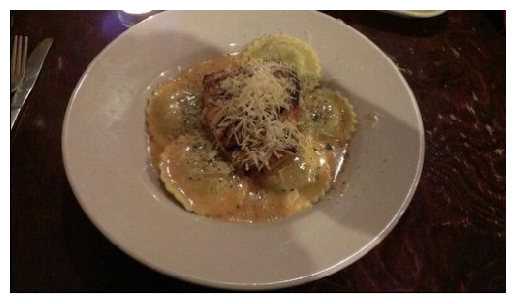

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = './dataset/images/grilled_salmon.jpg'
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
!python -m llava.serve.cli \
    --model-path llava-ftmodel \
    --image-file './dataset/images/grilled_salmon.jpg'

[2024-10-23 17:05:21,093] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2024-10-23 17:05:22.843143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 17:05:22.865291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 17:05:22.871741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 17:05:24.227802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprec